<Figure size 640x480 with 0 Axes>

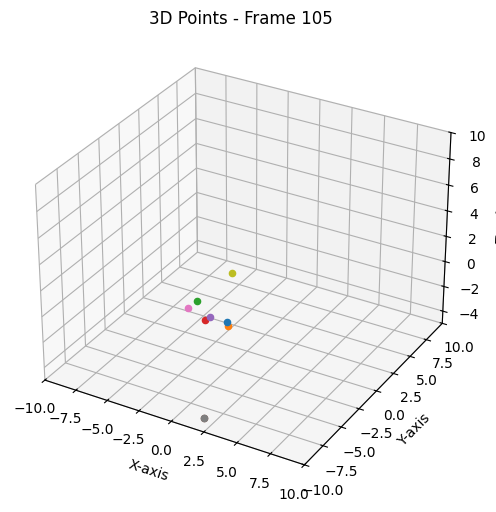

interactive(children=(IntSlider(value=104, description='frame_idx', max=208), Output()), _dom_classes=('widget…

In [6]:
import cv2
import numpy as np
import json

from ipywidgets import interactive
from matplotlib import pyplot as plt

class Recon3D(QThread):
    finished = pyqtSignal()
    def __init__(self, input_path, raw_coordinates):
        
        self.input_path = input_path
        self.raw_coordinates = raw_coordinates
        
        directory, filename = os.path.split(self.input_path)
        filename, ext = os.path.splitext(filename)
        self.output_path = f"{directory}/{filename}_coordinates.csv"

        # Load configuration file
        config_file = './config/AVATAR3D_config.json'
        with open(config_file, 'r') as file:
            cfg = json.load(file)
        
        camera_matrices = [np.array(mtx) for mtx in cfg["camera"]["calibration"]["camera_matrices"]]
        dist_coeffs = [np.array(dist) for dist in cfg["camera"]["calibration"]["dist_coeffs"]]
        rot_vectors = [np.array(rvec) for rvec in cfg["camera"]["calibration"]["rot_vectors"]]
        trans_vectors = [np.array(tvec) for tvec in cfg["camera"]["calibration"]["trans_vectors"]]
        square_size = cfg["camera"]["calibration"]["square_size_overide_mm"]
        
        # 각 카메라의 투영 행렬 계산
        projection_matrices = []
        for cam_idx, (K, rvec, tvec) in enumerate(zip(camera_matrices, rot_vectors, trans_vectors)):
            R, _ = cv2.Rodrigues(rvec)  # 회전 벡터를 회전 행렬로 변환
            T = tvec.reshape(3, 1)          # 변환 벡터
            RT = np.hstack((R, T))          # [R | T]
            P = np.dot(K, RT)               # 투영 행렬: K * [R | T]
            projection_matrices.append(P)
        
        # 평행이동과 회전을 위한 value: pre-determined
        INTERSECTION = [ 5.485472, 11.23394,  -6.582967]
        ROTATION_MATRIX = [[ 0.9940044, -0.09772341, -0.04904471],
         [-0.09772341, -0.59281272, -0.79938928],
         [0.04904471, 0.79938928, -0.59880832]]
        INTERSECTION = np.array(INTERSECTION)
        ROTATION_MATRIX = np.array(ROTATION_MATRIX)

    def transform_point(self, point):
        translated_point = point - INTERSECTION
        aligned_point = np.dot(translated_point, ROTATION_MATRIX.T)
        return aligned_point
    
    def triangulate_points(self, row, conf, camera_cnt):
        points_2d = np.array(row).reshape(5, 2)  # (x, y) 좌표로 변환
        
        # 왜곡 보정된 좌표로 변환
        undistorted_points = []
        for cam_idx, (pt, K, dist) in enumerate(zip(points_2d, camera_matrices, dist_coeffs)):
            pts = np.array([pt], dtype=np.float32).reshape(-1, 1, 2)
            undistorted = cv2.undistortPoints(pts, K, dist, None, K).reshape(-1, 2)
            undistorted_points.append(undistorted[0])
    
        # conf 높은 순으로 index 정렬
        sorted_indices = sorted(range(len(conf)), key=lambda i: conf[i], reverse=True)
        
        # 최소 두 카메라를 선택하여 삼각화 수행: (0,0)이 아닌 카메라 2개 찾기
        cam_idx = []
        points = []
        cnt = 0
        for i in sorted_indices:
            if(conf[i] > 0.25):
                cam_idx.append(i)
                points.append(np.array(undistorted_points[i], dtype=np.float32).reshape(2, 1))
                cnt += 1
    
        if(cnt < 2):
            return [0.0, 0.0, 0.0]
        else:   
            # Triangulation: 2D 좌표에서 3D 좌표 계산
            triangulated_point = cv2.triangulatePoints(
                projection_matrices[cam_idx[0]], projection_matrices[cam_idx[1]],
                points[0], points[1]
            )
        
            # 동차 좌표를 디카르트 좌표로 변환
            triangulated_point /= triangulated_point[3]
    
            # square_size 를 곱해서 실제 위치 계산
            triangulated_point = triangulated_point * square_size
    
            return triangulated_point[:3].flatten()

    def run(self):
        # Load points from file and process
        # points_data = np.loadtxt(input_file, delimiter="\t")  # Load the data from file
        points_data = self.raw_coordinates
        
        # Extract 2D points and confidences
        triangulated_points = []
        for row in points_data:
            triangulated_row = []  # Store triangulated points for one row
            for i in range(cfg['keypoint']['cnt']):
                points_2d = []
                conf = []
                for j in range(cfg['camera']['cnt']):
                    x, y, confidence = row[j*cfg['keypoint']['cnt']*3 + i*3 : j*cfg['keypoint']['cnt']*3 + i*3 + 3]
                    points_2d.append(x - cfg['camera']['roi'][j][0])
                    points_2d.append(y - cfg['camera']['roi'][j][1])
                    conf.append(confidence)
                
                point_3d = triangulate_points(points_2d, conf, cfg['camera']['cnt'])
                transformed_point = transform_point(point_3d) # 카메라 3을 z축 기준으로 전환
                
                triangulated_row.extend(transformed_point)
            
            triangulated_points.append(triangulated_row)
        
        # Save results to file
        np.savetxt(output_file, triangulated_points, fmt="%.6f", comments="", delimiter=",")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter

# CSV 파일에서 데이터 읽기
data = np.loadtxt('result.txt_result.csv', delimiter=',')  # CSV 파일 읽기

# 데이터 구조 확인
num_time_steps = data.shape[0]  # 시간 스텝 수 (행의 수)
num_points = 9  # 한 줄에 9개의 (x, y, z) 쌍

# 데이터를 (시간, 9, 3) 형태로 변환
data = data.reshape(num_time_steps, num_points, 3)

# 그래픽 창 표시 없이 백엔드 설정
import matplotlib
matplotlib.use('Agg')  # 그래픽 창을 띄우지 않음

# 3D 플롯 설정
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 축 설정
# ax.set_xlim(np.min(data[:, :, 0]) - 0.1, np.max(data[:, :, 0]) + 0.1)
# ax.set_ylim(np.min(data[:, :, 1]) - 0.1, np.max(data[:, :, 1]) + 0.1)
# ax.set_zlim(np.min(data[:, :, 2]) - 0.1, np.max(data[:, :, 2]) + 0.1)
ax.set_xlim(-10, 10)  # x축 범위
ax.set_ylim(-10, 10)  # y축 범위
ax.set_zlim(-5, 10)  # z축 범위
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

ax.set_title('Animated Movement of 9 Points Over Time')

# 각 점을 나타낼 스캐터 객체 생성
scatters = [ax.scatter([], [], [], label=f'Point {i+1}') for i in range(num_points)]
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

# 초기 프레임 설정
def init():
    for scatter in scatters:
        scatter._offsets3d = ([], [], [])
    return scatters

# 각 프레임 업데이트
def update(frame):
    for i, scatter in enumerate(scatters):
        x = data[frame, i, 0]
        y = data[frame, i, 1]
        z = data[frame, i, 2]
        scatter._offsets3d = ([x], [y], [z])
    return scatters

# 애니메이션 생성
ani = FuncAnimation(
    fig,
    update,
    frames=num_time_steps,
    init_func=init,
    blit=False,
    interval=100  # 프레임당 시간(ms)
)

# 애니메이션 저장
output_file = 'results.mp4'
writer = FFMpegWriter(fps=10, metadata={'title': '3D Point Animation'})
ani.save(output_file, writer=writer)

print(f"애니메이션이 {output_file} 파일로 저장되었습니다.")


애니메이션이 results.mp4 파일로 저장되었습니다.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter

# CSV 파일에서 데이터 읽기
data = np.loadtxt('triangulated_points.csv', delimiter=',')

# 데이터 구조 확인
num_time_steps = data.shape[0]  # 시간 스텝 수 (행의 수)
num_points = 9  # 한 줄에 9개의 (x, y, z) 쌍

# 데이터를 (시간, 9, 3) 형태로 변환
data = data.reshape(num_time_steps, num_points, 3)

# 그래픽 창 표시 없이 백엔드 설정
import matplotlib
matplotlib.use('Agg')  # 그래픽 창을 띄우지 않음

# 3D 플롯 설정
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 축 설정
ax.set_xlim(np.min(data[:, :, 0]) - 0.1, np.max(data[:, :, 0]) + 0.1)
ax.set_ylim(np.min(data[:, :, 1]) - 0.1, np.max(data[:, :, 1]) + 0.1)
# ax.set_zlim(np.min(data[:, :, 2]) - 0.1, np.max(data[:, :, 2]) + 0.1)
ax.set_zlim(-1, 10)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Animated Movement of 9 Points with Lines')

# 각 점을 나타낼 스캐터 객체 생성
scatters = [ax.scatter([], [], [], label=f'Point {i+1}') for i in range(num_points)]
lines = [ax.plot([], [], [], linewidth=1.5)[0] for _ in range(8)]  # 8개의 선 추가
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

# 선을 이을 인덱스 (0부터 시작)
line_indices = [
    (0, 1),  # Point 1 ↔ Point 2
    (1, 3),  # Point 2 ↔ Point 4
    (2, 3),  # Point 3 ↔ Point 4
    (3, 4),  # Point 4 ↔ Point 5
    (3, 5),  # Point 4 ↔ Point 6
    (1, 6),  # Point 2 ↔ Point 7
    (1, 7),  # Point 2 ↔ Point 8
    (2, 8),  # Point 3 ↔ Point 9
]

# 초기 프레임 설정
def init():
    for scatter in scatters:
        scatter._offsets3d = ([], [], [])
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return scatters + lines

# 각 프레임 업데이트
def update(frame):
    for i, scatter in enumerate(scatters):
        x = data[frame, i, 0]
        y = data[frame, i, 1]
        z = data[frame, i, 2]
        scatter._offsets3d = ([x], [y], [z])
    
    for i, (start, end) in enumerate(line_indices):
        x = [data[frame, start, 0], data[frame, end, 0]]
        y = [data[frame, start, 1], data[frame, end, 1]]
        z = [data[frame, start, 2], data[frame, end, 2]]
        lines[i].set_data(x, y)
        lines[i].set_3d_properties(z)
    
    return scatters + lines

# 애니메이션 생성
ani = FuncAnimation(
    fig,
    update,
    frames=num_time_steps,
    init_func=init,
    blit=False,
    interval=100  # 프레임당 시간(ms)
)

# 애니메이션 저장
output_file = 'points_with_lines_animation.mp4'
writer = FFMpegWriter(fps=10, metadata={'title': '3D Point Animation with Lines'})
ani.save(output_file, writer=writer)

print(f"애니메이션이 {output_file} 파일로 저장되었습니다.")


애니메이션이 points_with_lines_animation.mp4 파일로 저장되었습니다.


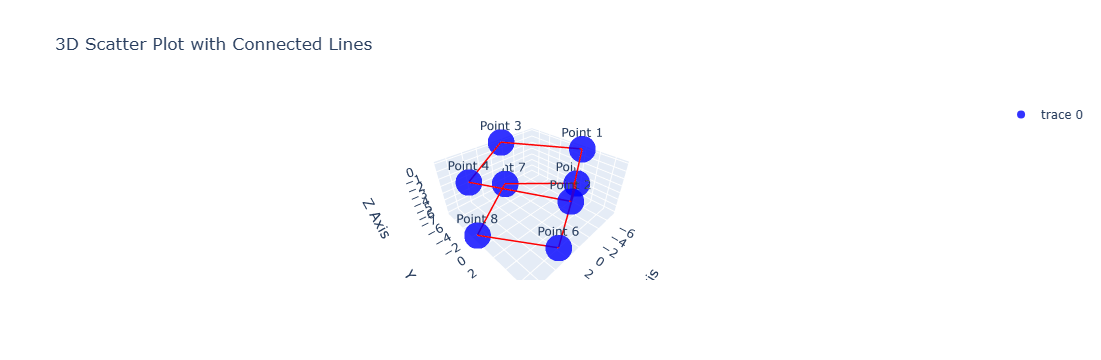

In [21]:
import pandas as pd
import plotly.graph_objects as go

# CSV 파일 불러오기
file_path = '8_edge_result.csv'
df = pd.read_csv(file_path, header = None)

# Plotly로 3D 산점도 생성
fig = go.Figure()

# 8개의 점 추가
fig.add_trace(go.Scatter3d(
    x=df.iloc[:, 0],  # 첫 번째 열 (x 좌표)
    y=df.iloc[:, 1],  # 두 번째 열 (y 좌표)
    z=df.iloc[:, 2],  # 세 번째 열 (z 좌표)
    mode='markers+text',
    marker=dict(
        size=8,
        color='blue',
        opacity=0.8
    ),
    text=[f'Point {i+1}' for i in range(8)],
    textposition="top center"
))

# 선(Line) 연결 관계 정의
connections = [
    (0, 1), (3, 2), (1, 3), (2, 0),  # 1-2, 2-3, 3-4, 4-1
    (4, 5), (4, 6), (6, 7), (7, 5)   # 5-6, 6-7, 7-8, 8-1
]

# 연결된 선 추가
for start, end in connections:
    fig.add_trace(go.Scatter3d(
        x=[df.iloc[start, 0], df.iloc[end, 0]],
        y=[df.iloc[start, 1], df.iloc[end, 1]],
        z=[df.iloc[start, 2], df.iloc[end, 2]],
        mode='lines',
        line=dict(
            color='red',
            width=3
        ),
        showlegend=False
    ))

# 레이아웃 설정
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot with Connected Lines'
)

# 그래프 표시
fig.show()


In [4]:
import json
config_file = './config/AVATAR3D_config.json'

with open(config_file, 'r') as file:
    cfg = json.load(file)

print(cfg['camera']['roi'][0][0])

0
